## Install some libraries

In [1]:
!pip install tensorflow pandas scikit-learn yfinance

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
import calendar
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf

pd.set_option('display.max_columns',None)

## Load the data

In [3]:
sgx = pd.read_csv('/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/Data/Gift Nifty 50 Futures Historical Data.csv')
sgx.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,15-11-2024,"23,571.50","23,650.00","23,677.00","23,404.00",18.86K,-0.29%
1,14-11-2024,"23,641.00","23,640.50","23,752.50","23,559.00",50.24K,-0.01%
2,13-11-2024,"23,643.50","23,899.00","23,938.00","23,595.00",59.36K,-1.23%
3,12-11-2024,"23,938.00","24,225.00","24,312.00","23,855.50",46.75K,-1.17%
4,11-11-2024,"24,221.50","24,133.00","24,428.00","24,085.00",43.00K,0.09%


In [4]:

df_sgx = sgx[['Date','Open']].rename(columns={'Open':'gift_open'})

# Convert 'Date' to datetime format (considering it's in 'dd-mm-yyyy' format)
df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%d-%m-%Y')

# Remove commas from the 'Open' column and convert to float
df_sgx['gift_open'] = df_sgx['gift_open'].replace({',': ''}, regex=True).astype(float)
df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%Y-%m-%d')

df_sgx['gift_open'] = df_sgx['gift_open'].shift(1)


# Check the updated dataframe
print(df_sgx.tail())




          Date  gift_open
933 2021-04-05   14749.90
934 2021-04-01   14805.25
935 2021-03-31   14851.60
936 2021-03-30   14876.90
937 2021-03-29   14727.00


In [5]:
start_date = "2021-01-01"
end_date   = "2024-11-30"

data = yf.download("^NSEI", start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0) # from multi index to single index

data = data.reset_index()

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                      Date     Adj Close         Close          High  \
0     2021-01-01 00:00:00+00:00  14018.500000  14018.500000  14049.849609   
1     2021-01-04 00:00:00+00:00  14132.900391  14132.900391  14147.950195   
2     2021-01-05 00:00:00+00:00  14199.500000  14199.500000  14215.599609   
3     2021-01-06 00:00:00+00:00  14146.250000  14146.250000  14244.150391   
4     2021-01-07 00:00:00+00:00  14137.349609  14137.349609  14256.250000   

Price           Low          Open  Volume  
0      13991.349609  13996.099609  358100  
1      13953.750000  14104.349609  495000  
2      14048.150391  14075.150391  492500  
3      14039.900391  14240.950195  632300  
4      14123.099609  14253.750000  559200  


In [6]:
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [7]:

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date']).dt.date

df_train_all = data.copy()


In [8]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'], format='%Y-%m-%d')

df_train_all         = df_train_all.merge(df_sgx, how = 'left', on = 'Date' )
df_train_all.tail()


,Date,Adj Close,Close,High,Low,Open,Volume,gift_open
961,2024-11-25,24221.900391,24221.900391,24351.550781,24135.449219,24253.550781,687200,NaN
962,2024-11-26,24194.500000,24194.500000,24343.300781,24125.400391,24343.300781,230700,NaN
963,2024-11-27,24274.900391,24274.900391,24354.550781,24145.650391,24204.800781,295000,NaN
964,2024-11-28,23914.150391,23914.150391,24345.750000,23873.349609,24274.150391,366700,NaN
965,2024-11-29,24131.099609,24131.099609,24188.449219,23927.150391,23927.150391,282100,NaN


## Feature engineering

In [9]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()

df_train_all.dropna(subset=['100DMA'], inplace=True)

In [10]:

def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [11]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)  # Daily changes
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_train_all['RSI'] = calculate_rsi(df_train_all)


In [12]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

df_train_all['MACD'], df_train_all['Signal_Line'] = calculate_macd(df_train_all)


In [13]:
def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (num_std_dev * std)
    lower_band = sma - (num_std_dev * std)
    return sma, upper_band, lower_band

df_train_all['SMA'], df_train_all['Upper_Band'], df_train_all['Lower_Band'] = calculate_bollinger_bands(df_train_all)


In [14]:
def calculate_obv(data):
    obv = [0]  # Initialize OBV with the first value as 0
    for i in range(1, len(data)):
        if data['Close'].iloc[i] > data['Close'].iloc[i - 1]:
            obv.append(obv[-1] + data['Volume'].iloc[i])
        elif data['Close'].iloc[i] < data['Close'].iloc[i - 1]:
            obv.append(obv[-1] - data['Volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=data.index)  # Convert to a pandas Series

df_train_all['OBV'] = calculate_obv(df_train_all)



In [15]:
df_train_all.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'gift_open', '10DMA', '30DMA', '100DMA', 'RSI', 'MACD', 'Signal_Line',
       'SMA', 'Upper_Band', 'Lower_Band', 'OBV'],
      dtype='object')

In [16]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])

df_train_all['day'] = df_train_all['Date'].dt.strftime("%A")
le_day = LabelEncoder()
df_train_all['day'] = le_day.fit_transform(df_train_all['day'])

df_train_all['date_no'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


In [17]:
df_train_all['next_close'] = df_train_all['Close'].shift(-1)
df_train_all['target'] = df_train_all['next_close'] - df_train_all['Close']
df_train_all.dropna(subset=['target'], inplace=True)

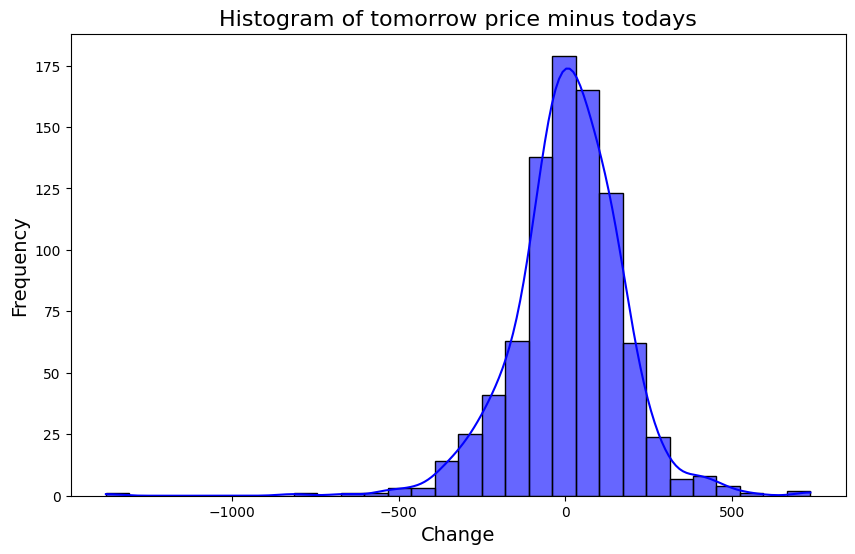

In [18]:


# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_train_all['target'].dropna(), bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [19]:
skewness = df_train_all['target'].skew()
print(f"Skewness of target: {skewness}")


Skewness of target: -0.795173405948854


### Show how min max transform will preserve the original distribution

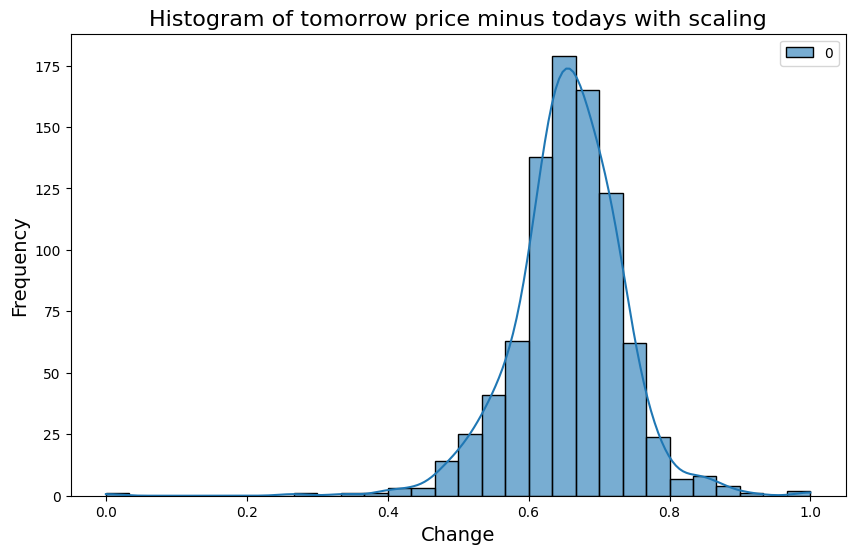

In [20]:
mm = MinMaxScaler()
ss = mm.fit_transform(df_train_all[['target']])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays with scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

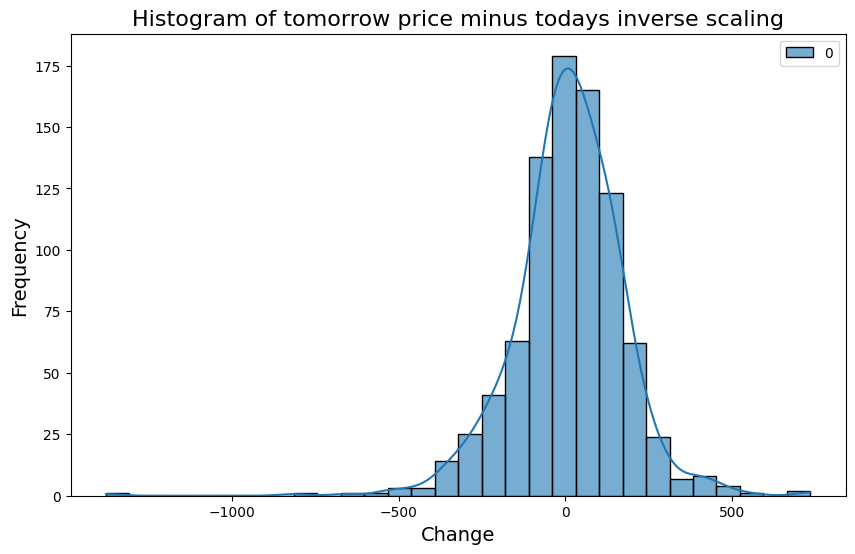

In [21]:
ss_inv = mm.inverse_transform(ss)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss_inv, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays inverse scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Back on route

In [22]:
df_train_all.head()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,RSI,MACD,Signal_Line,SMA,Upper_Band,Lower_Band,OBV,day,date_no,month,year,opt_exp,next_close,target
99,2021-05-31,15582.799805,15582.799805,15606.349609,15374.000000,15437.750000,436000,15635.35,15228.350000,14840.676660,14736.996982,NaN,0.000000,0.000000,NaN,NaN,NaN,0,1,31,5,0,0,15574.849609,-7.950195
100,2021-06-01,15574.849609,15574.849609,15660.750000,15528.299805,15629.650391,409600,15567.10,15275.025000,14872.576660,14752.560479,0.000000,-0.634204,-0.126841,NaN,NaN,NaN,-409600,3,1,6,0,0,15576.200195,1.350586
101,2021-06-02,15576.200195,15576.200195,15597.450195,15459.849609,15520.349609,428600,15709.85,15329.629980,14913.134993,14766.993477,14.521210,-1.016120,-0.304697,NaN,NaN,NaN,19000,4,2,6,0,0,15690.349609,114.149414
102,2021-06-03,15690.349609,15690.349609,15705.099609,15611.000000,15655.549805,410200,15687.40,15408.059961,14959.599967,14781.901973,93.559998,7.802173,1.316677,NaN,NaN,NaN,429200,2,3,6,0,0,15670.250000,-20.099609
103,2021-06-04,15670.250000,15670.250000,15733.599609,15622.349609,15712.500000,414200,15728.45,15457.554980,15001.736621,14797.141973,80.459880,13.018791,3.657100,NaN,NaN,NaN,15000,0,4,6,0,0,15751.650391,81.400391


In [23]:
df_train_all['prev_close'] = df_train_all['Close'].shift(1)

df_train_all['pct_change_in_a_day'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['act_change_in_a_day'] = df_train_all['Close']-df_train_all['Open']
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
df_train_all['range_avg'] =  df_train_all['daily_move'].rolling(window=5).mean() #average of last 5 day movement
df_train_all['change_avg'] =  df_train_all['act_change_in_a_day'].rolling(window=5).mean()


In [24]:
df_train_all.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,RSI,MACD,Signal_Line,SMA,Upper_Band,Lower_Band,OBV,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
960,2024-11-22,23907.250000,23907.250000,23956.099609,23359.000000,23411.800781,367600,NaN,23769.350000,24301.161654,24705.270957,44.515388,-328.951834,-311.061077,24031.147559,24757.500343,23304.794774,17168200,0,22,11,3,0,24221.900391,314.650391,23349.900391,1.021162,495.449219,61.900391,597.099609,321.050000,36.979687
961,2024-11-25,24221.900391,24221.900391,24351.550781,24135.449219,24253.550781,687200,NaN,23771.605078,24275.276693,24706.070469,48.594576,-272.356243,-303.320110,24022.272559,24733.867643,23310.677474,17855400,1,25,11,3,0,24194.500000,-27.400391,23907.250000,0.998695,-31.650391,346.300781,216.101562,325.920313,32.539844
962,2024-11-26,24194.500000,24194.500000,24343.300781,24125.400391,24343.300781,230700,NaN,23776.235156,24249.618359,24706.776973,53.755216,-227.096979,-288.075484,24022.957520,24735.221167,23310.693872,17624700,3,26,11,3,0,24274.900391,80.400391,24221.900391,0.993887,-148.800781,121.400391,217.900391,318.220312,33.079687
963,2024-11-27,24274.900391,24274.900391,24354.550781,24145.650391,24204.800781,295000,NaN,23789.595117,24221.183398,24706.660977,51.225083,-182.635736,-266.987534,24019.745020,24726.562724,23312.927316,17919700,4,27,11,3,0,23914.150391,-360.750000,24194.500000,1.002896,70.099609,10.300781,208.900391,296.830469,49.309766
964,2024-11-28,23914.150391,23914.150391,24345.750000,23873.349609,24274.150391,366700,NaN,23792.665234,24183.076758,24702.780977,39.057631,-174.497887,-248.489605,23992.110059,24667.860309,23316.359808,17553000,2,28,11,3,1,24131.099609,216.949219,24274.900391,0.985169,-360.000000,-0.750000,472.400391,342.480469,5.019531


In [25]:
split_date   = '2024-03-31'

df_train = df_train_all[df_train_all['Date']<=  split_date] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  split_date] #keeping last year for testing

In [26]:
df_lstm_results  = pd.DataFrame()

In [27]:
df_test.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,RSI,MACD,Signal_Line,SMA,Upper_Band,Lower_Band,OBV,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
960,2024-11-22,23907.250000,23907.250000,23956.099609,23359.000000,23411.800781,367600,NaN,23769.350000,24301.161654,24705.270957,44.515388,-328.951834,-311.061077,24031.147559,24757.500343,23304.794774,17168200,0,22,11,3,0,24221.900391,314.650391,23349.900391,1.021162,495.449219,61.900391,597.099609,321.050000,36.979687
961,2024-11-25,24221.900391,24221.900391,24351.550781,24135.449219,24253.550781,687200,NaN,23771.605078,24275.276693,24706.070469,48.594576,-272.356243,-303.320110,24022.272559,24733.867643,23310.677474,17855400,1,25,11,3,0,24194.500000,-27.400391,23907.250000,0.998695,-31.650391,346.300781,216.101562,325.920313,32.539844
962,2024-11-26,24194.500000,24194.500000,24343.300781,24125.400391,24343.300781,230700,NaN,23776.235156,24249.618359,24706.776973,53.755216,-227.096979,-288.075484,24022.957520,24735.221167,23310.693872,17624700,3,26,11,3,0,24274.900391,80.400391,24221.900391,0.993887,-148.800781,121.400391,217.900391,318.220312,33.079687
963,2024-11-27,24274.900391,24274.900391,24354.550781,24145.650391,24204.800781,295000,NaN,23789.595117,24221.183398,24706.660977,51.225083,-182.635736,-266.987534,24019.745020,24726.562724,23312.927316,17919700,4,27,11,3,0,23914.150391,-360.750000,24194.500000,1.002896,70.099609,10.300781,208.900391,296.830469,49.309766
964,2024-11-28,23914.150391,23914.150391,24345.750000,23873.349609,24274.150391,366700,NaN,23792.665234,24183.076758,24702.780977,39.057631,-174.497887,-248.489605,23992.110059,24667.860309,23316.359808,17553000,2,28,11,3,1,24131.099609,216.949219,24274.900391,0.985169,-360.000000,-0.750000,472.400391,342.480469,5.019531


In [28]:
df_train.dropna(subset=['range_avg'], inplace=True)
df_train.dropna(subset=['gift_open'], inplace=True)
df_train.columns

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_24261/637183717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['range_avg'], inplace=True)
/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_24261/637183717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['gift_open'], inplace=True)


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'gift_open', '10DMA', '30DMA', '100DMA', 'RSI', 'MACD', 'Signal_Line',
       'SMA', 'Upper_Band', 'Lower_Band', 'OBV', 'day', 'date_no', 'month',
       'year', 'opt_exp', 'next_close', 'target', 'prev_close',
       'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
       'daily_move', 'range_avg', 'change_avg'],
      dtype='object')

In [29]:
          
df = df_train.copy()
df = df.dropna()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume',
                    'gift_open', '10DMA', '30DMA', '100DMA', 'day', 'date_no',
                    'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
                    'daily_move', 'range_avg', 'change_avg',
                    'RSI', 'MACD', 'Signal_Line', 'SMA', 'Upper_Band', 'Lower_Band', 'OBV']

# features_to_scale = [ 'Volume', 'Close',  
#                      'act_change_in_a_day',
#                      'range_avg', 'change_avg']

features_to_leave = ['opt_exp' ]

df[features_to_scale].head()

,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,day,date_no,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg,RSI,MACD,Signal_Line,SMA,Upper_Band,Lower_Band,OBV
118,15860.349609,15870.799805,15772.299805,15839.349609,314600,15913.75,15768.039941,15535.429948,15004.984961,0,25,1.001326,21.000000,48.899414,98.500000,161.870117,10.240234,56.143273,45.337827,40.998644,15721.952393,15895.706101,15548.198684,629300
119,15814.700195,15915.650391,15792.150391,15915.349609,255100,15845.70,15768.325000,15565.148275,15026.785967,1,28,0.993676,-100.649414,55.000000,123.500000,134.670117,-54.019727,54.059676,46.802536,42.159422,15733.547412,15898.952173,15568.142651,374200
120,15748.450195,15835.900391,15724.049805,15807.500000,360300,15830.90,15756.245020,15586.493294,15041.458467,3,29,0.996264,-59.049805,-7.200195,111.850586,128.310156,-52.279688,56.423981,42.131837,42.153905,15742.227441,15889.828778,15594.626105,13900
121,15721.500000,15839.099609,15708.750000,15776.900391,262400,15753.95,15751.640039,15609.538281,15052.194971,4,30,0.996489,-55.400391,28.450195,130.349609,116.580078,-28.189844,48.990495,35.842450,40.891614,15749.492432,15875.393991,15623.590872,-248500
122,15680.000000,15755.549805,15667.049805,15755.049805,224900,15740.10,15750.500000,15635.336621,15061.095469,2,1,0.995236,-75.049805,33.549805,88.500000,110.540039,-53.829883,42.395692,27.195865,38.152464,15748.974951,15875.980282,15621.969621,-473400


In [30]:

features = features_to_scale + features_to_leave
target = 'target'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

print("X_train_reshaped shape:", X_train_scaled.shape)
print("y_train_reshaped shape:", y_train_scaled.shape)
print("X_test_reshaped shape:", X_test_scaled.shape)
print("y_test_reshaped shape:", y_test_scaled.shape)



X_train_reshaped shape: (545, 25)
y_train_reshaped shape: (545, 1)
X_test_reshaped shape: (137, 25)
y_test_reshaped shape: (137, 1)


In [31]:
timesteps = 60

In [32]:

# Function to create sequences for LSTM
def create_sequences(data, target, timesteps):
    sequences = []
    targets = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i+timesteps, :])
        targets.append(target[i+timesteps-1])  # Use the last value in the window as the target
    return np.array(sequences), np.array(targets)

# Create LSTM-compatible sequences
X_train_reshaped, y_train_reshaped = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train_reshaped shape:", y_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)



X_train_reshaped shape: (486, 60, 25)
y_train_reshaped shape: (486, 1)
X_test_reshaped shape: (78, 60, 25)
y_test_reshaped shape: (78, 1)


In [33]:

# Build your LSTM model
model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2]))))
#model.add((LSTM(64, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2]))))
model.add(Dropout(0.1))

model.add(Bidirectional(GRU(64, return_sequences=False)))
#model.add((LSTM(64, return_sequences=False)))
model.add(Dropout(0.1))

model.add(Dense(32))
model.add(Dropout(0.1))

model.add(Dense(1))

model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# Train the model
history = model.fit(X_train_reshaped, 
                    y_train_reshaped, 
                    epochs=100, 
                    validation_data=(X_test_reshaped, y_test_reshaped), 
                    batch_size=32,
                    callbacks=[early_stopping])


/opt/anaconda3/envs/Conda_3_12_7/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1805 - mae: 0.3429 - mse: 0.1805 - val_loss: 0.4411 - val_mae: 0.6463 - val_mse: 0.4411
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0888 - mae: 0.2352 - mse: 0.0888 - val_loss: 0.1191 - val_mae: 0.3174 - val_mse: 0.1191
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0605 - mae: 0.1966 - mse: 0.0605 - val_loss: 0.0497 - val_mae: 0.1870 - val_mse: 0.0497
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0407 - mae: 0.1661 - mse: 0.0407 - val_loss: 0.0341 - val_mae: 0.1488 - val_mse: 0.0341
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0454 - mae: 0.1665 - mse: 0.0454 - val_loss: 0.0165 - val_mae: 0.1026 - val_mse: 0.0165
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0388 - mae: 0.1584 - mse: 0.0388 - val_loss: 0.0172 - val_mae: 0.1044 - val_mse: 0.0172
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0342 - mae: 0.1488 - mse: 0.0342 - val

In [34]:

##############################################################################################
#########################          Checking val performance              #############################
##############################################################################################


# Predictions
lstm_predictions = model.predict(X_test_reshaped)
lstm_predictions = lstm_predictions.reshape(-1,1)

# Ensure both predictions and actual values are of type float64
y_test_reshaped = y_test_reshaped.reshape(-1, 1).astype('float64')
lstm_predictions_scaled = lstm_predictions.astype('float64')


y_test_actual = target_scaler.inverse_transform(y_test_reshaped).astype('float64')
lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')
results_test_unscaled   = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Validation performance: ",results_test_unscaled)

#

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0946 - mse: 0.0147 
Validation performance:  [0.014821321703493595, 0.09604462236166, 0.014821321703493595]


## Applying model on Test Data

In [35]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()
#df = df_train_all.copy()  #change 1: to make prediction on whole data

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part        = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled             = np.hstack((X_test_scaled_part, df[features_to_leave].values))
#X_test_reshaped           = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

y_test_scaled             = target_scaler.transform(df['target'].values.reshape(-1, 1))


X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)


test_performance          = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Test performance (MAE): ", test_performance[1])





X_test_reshaped shape: (105, 60, 25)
y_test_reshaped shape: (105, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: nan - mae: nan - mse: nan          
Test performance (MAE):  nan


In [36]:
model.predict(X_test_reshaped).shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


(105, 1)

In [37]:
df_test.shape[0] - lstm_predictions_actual.shape[0]

86

In [38]:
# Predictions
lstm_predictions         = model.predict(X_test_reshaped)
lstm_predictions_scaled  = lstm_predictions.astype('float64')

lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')

df_test_prediction      = df_test[(timesteps- 1):].copy() 
#df_test_prediction      = df_train_all[(timesteps- 1):].copy() #change 2: to make prediction on whole data

# Add predictions to the dataframe
df_test_prediction['change_predicted'] = lstm_predictions_actual



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [39]:

df_test_prediction['predicted_close'] = df_test_prediction['Close'] + df_test_prediction['change_predicted']

In [40]:
df_test_prediction.dropna(subset=['predicted_close'], inplace=True)

In [41]:
df_test_prediction['prediction_diff'] =  df_test_prediction['predicted_close']-df_test_prediction['next_close']
df_test_prediction['pct_prediction_diff'] = df_test_prediction['prediction_diff']/df_test_prediction['next_close']*100

df_test_prediction[['next_close','predicted_close','prediction_diff','pct_prediction_diff']]


,next_close,predicted_close,prediction_diff,pct_prediction_diff
860,24141.949219,24091.998889,-49.950330,-0.206903
861,24123.849609,24192.427461,68.577852,0.284274
862,24286.500000,24141.238531,-145.261469,-0.598116
863,24302.150391,24289.267847,-12.882543,-0.053010
864,24323.849609,24318.337579,-5.512031,-0.022661
...,...,...,...,...
952,24141.300781,24134.432790,-6.867991,-0.028449
953,23883.449219,24113.546722,230.097503,0.963418
954,23559.050781,23831.877040,272.826258,1.158053
955,23532.699219,23483.650374,-49.048845,-0.208428


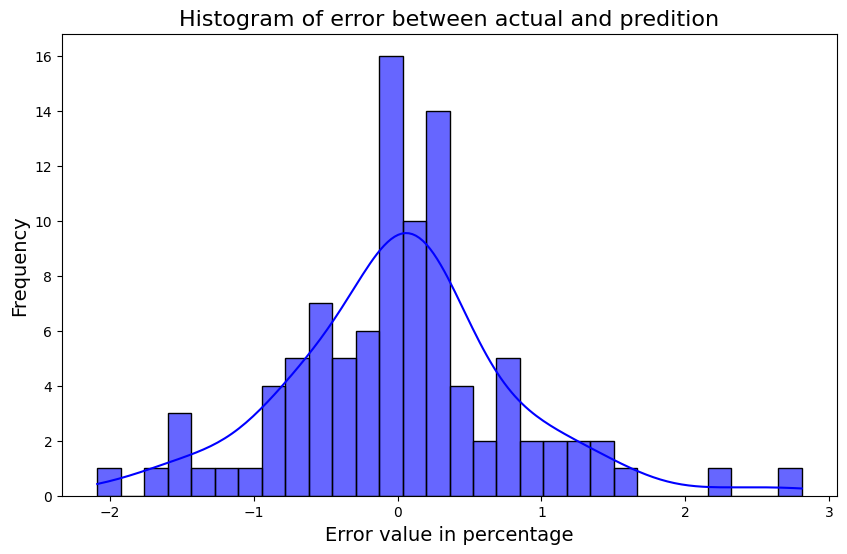

In [42]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_test_prediction['pct_prediction_diff'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of error between actual and predition', fontsize=16)
plt.xlabel('Error value in percentage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

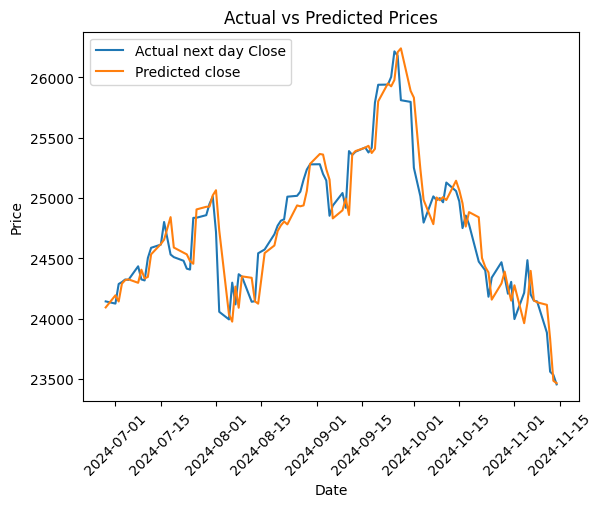

In [43]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['next_close'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['predicted_close'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

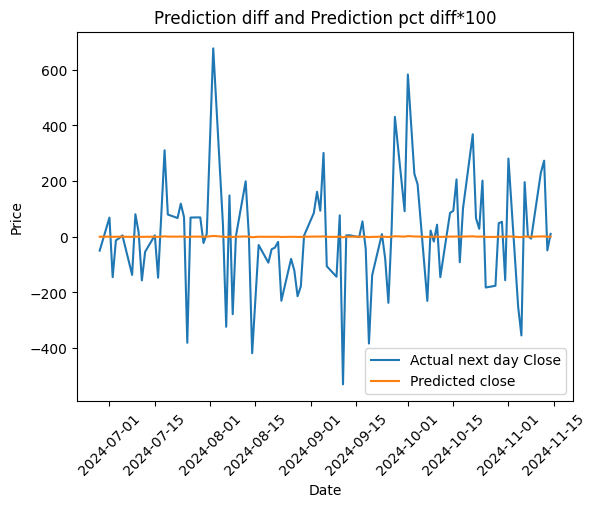

In [44]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['prediction_diff'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['pct_prediction_diff'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Prediction diff and Prediction pct diff*100')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [45]:
print("average percentage difference", df_test_prediction['pct_prediction_diff'].abs().mean())
print("average points difference", df_test_prediction['prediction_diff'].abs().mean())

average percentage difference 0.5641213354061484
average points difference 139.55253001770782


In [46]:
needed_columns = ['Date', 'next_close', 'predicted_close', 'prediction_diff', 'pct_prediction_diff']

df_test_sample = df_test_prediction[needed_columns]


# Generate new column names
new_columns = {col: f"{col}_{timesteps}" for col in needed_columns[2:]}

# Rename the columns in the DataFrame (excluding 'Date')
df_test_sample = df_test_sample.rename(columns=new_columns)


In [50]:
save_wip_folder  = '/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/MSDS_458_Group_N/03_LSTM_timeseries/WIP_files/' 
file_name        = 'predictions_BIGRU'+str(timesteps) + '.csv'
save_wip         = save_wip_folder + file_name

df_test_sample.to_csv(save_wip)

In [48]:
df_test_sample.head()

,Date,next_close,predicted_close_60,prediction_diff_60,pct_prediction_diff_60
860,2024-06-28,24141.949219,24091.998889,-49.950330,-0.206903
861,2024-07-01,24123.849609,24192.427461,68.577852,0.284274
862,2024-07-02,24286.500000,24141.238531,-145.261469,-0.598116
863,2024-07-03,24302.150391,24289.267847,-12.882543,-0.053010
864,2024-07-04,24323.849609,24318.337579,-5.512031,-0.022661


In [49]:
print("Average prediction error :", round(df_test_sample['pct_prediction_diff_60'].abs().mean(),2), "%")

Average prediction error : 0.56 %
